# Analysis of the German Cellular Networks
In this Notebook, the german cellular networks are analysed using the Mozilla mls data.

There are some caveats here: This analysis is based on the correctness of the mls data, which probably also contains old or deprecated cells.
Furthermore, I am no expert on cellular network technology, so please let me know about errors.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gzip
import urllib.request
import io

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Importing the data and preprocessing
The data is downloaded here.
Furthermore, the data is filtered to only contain german LTE cells.

In [3]:
today = datetime.date.today().strftime('%Y-%m-%d')
baseURL = "https://d3r3tk5171bc5t.cloudfront.net/export/"
filename = "MLS-full-cell-export-"+today+"T000000.csv.gz"
outFilePath = datetime.date.today().strftime('%Y%m%d')+'.csv.gz'


#with open(outFilePath, 'wb') as outfile:
#    #outfile.write(gzip.decompress(response.read()))
#    outfile.write 

In [10]:
#cells = pd.read_csv('mls20181201.csv')
response = urllib.request.urlopen(baseURL+filename)
cells = pd.read_csv(io.BytesIO(response.read()), compression='gzip')

In [11]:
import math

# derived from the Java version explained here: http://wiki.openstreetmap.org/wiki/Mercator
RADIUS = 6378137.0 # in meters on the equator

def lat2y(a):
  return math.log(math.tan(math.pi / 4 + math.radians(a) / 2)) * RADIUS

def lon2x(a):
  return math.radians(a) * RADIUS

def addWebMercartor(tab):
    tempTab = tab.assign(lon6 = tab.lon.apply(lon2x))
    tempTab = tempTab.assign(lat6 = tab.lat.apply(lat2y))
    return tempTab

In [12]:
# add some more colums, readable time and tower ids
def addInfo(df):
    df['eNB'] = df['cell']//(256)
    df['sector']=df['cell']%256
    df['updatedP'] = pd.to_datetime(df['updated'], unit="s")
    df['createdR'] = pd.to_datetime(df.created, unit='s')
    df.updated = pd.to_datetime(df.updated, unit='s')


In [13]:
addInfo(cells)
cells = addWebMercartor(cells)

In [14]:
cellsLTE = cells.query('radio=="LTE"')

In [15]:
cellsDeLte = cellsLTE.query('mcc==262 and lon>5 and lon<15.5 and lat>47 and lat<55.5')
#cellsFR = cells.query('mcc==208 and radio=="LTE" and lon>5 and lon<15.5 and lat>47 and lat<55.5')
#del cells

#cellsDE = cells[cells.mcc==262]
#cellsDeLte = cellsDE[cellsDE.radio=='LTE']

In [16]:
# create one
def filterAndGroup(net, samples, timeU):
    testdelta = datetime.timedelta(1)
    testdelta2 = datetime.timedelta(30)
    testnew = datetime.datetime.today()-testdelta2
    
    tmp = cellsDeLte.query('net==@net and samples>@samples and updated>@timeU and eNB>9999').groupby('eNB').agg({'lat':np.mean, 'lon':np.mean,'lat6':np.mean, 'lon6':np.mean, 'samples':np.sum, 'created':np.min,'createdR':np.min, 'updated':np.max, 'sector':np.count_nonzero})
    #tmp['createdR'] = pd.to_datetime(tmp.created, unit='s')
    #tmp.updated = pd.to_datetime(tmp.updated, unit='s')
    tmp['id'] = tmp.index.values
    return tmp.query('updated-createdR >= @testdelta or createdR>@testnew')

In [17]:
timedec = datetime.datetime(2018,11,20)

In [18]:
#cutoff = datetime.datetime(2018,1,1).timestamp()
cutoff = pd.Timestamp(2018,1,1)
dt = filterAndGroup(1,3,cutoff)
vf = filterAndGroup(2,3,cutoff)
o2 = filterAndGroup(3,3,cutoff)


## Data Analysis
Now, let's look at the data. First, the development of the networks over time is analysed.

In [19]:
print('Number of towers')
print('o2\t'+str(len(o2))+'\nTelekom\t'+str(len(dt))+'\nVF\t'+(str(len(vf))))

Number of towers
o2	14428
Telekom	26939
VF	17292


In [20]:
print('Number of cells')
print('o2\t '+str(len(cellsDeLte.query('net==3')))+'\nTelekom\t'+str(len(cellsDeLte.query('net==1')))+'\nVF\t '+(str(len(cellsDeLte.query('net==2')))))

Number of cells
o2	 72026
Telekom	110574
VF	 64707


In [21]:
now = int(datetime.datetime.now().strftime('%s'))

In [22]:
timepoints = []
start = datetime.datetime(2017,1,1)
#step = datetime.timedelta(7)
now = datetime.datetime.now()
#for i in range(start, now, step):
#    timepoints.append(i)
#tpH = pd.to_datetime(timepoints, unit="s")
timepoints = pd.date_range(start, now, freq="w")

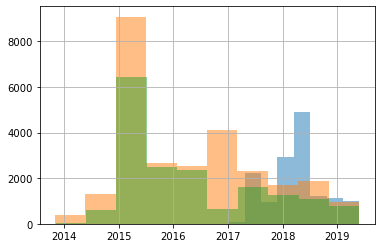

In [23]:
o2.createdR.hist(alpha=0.5)
dt.createdR.hist(alpha=0.5)
vf.createdR.hist(alpha=0.5)
plt.show()

In [26]:
towers = pd.DataFrame(index=timepoints, columns=['Telekom', 'Vodafone', 'O2'])
for i in timepoints:
    upCheck = i-datetime.timedelta(days=365)
    numberDT= len(dt.query('createdR<@i and updated>@upCheck'))
    numberVF= len(vf.query('createdR<@i and updated>@upCheck'))
    numberO2= len(o2.query('createdR<@i and updated>@upCheck'))
  
    towers.loc[i]=[numberDT, numberVF, numberO2]
towers

Telekom  Vodafone     O2
2017-01-01    18719     12492      7
2017-01-08    18793     12499      7
2017-01-15    18850     12510      8
2017-01-22    18899     12512      9
2017-01-29    18935     12519     12
2017-02-05    18964     12527     12
2017-02-12    19137     12533     12
2017-02-19    19244     12544     13
2017-02-26    19783     12559     16
2017-03-05    20125     12568     16
2017-03-12    20429     12580     16
2017-03-19    20647     12599     17
2017-03-26    20815     12628     17
2017-04-02    20950     12653     17
2017-04-09    21053     12693     21
2017-04-16    21153     12758     63
2017-04-23    21218     12936     72
2017-04-30    21268     12987     73
2017-05-07    21318     13038     81
2017-05-14    21382     13070     88
2017-05-21    21498     13095     91
2017-05-28    21593     13117     98
2017-06-04    21649     13141    102
2017-06-11    21683     13163    104
2017-06-18    21711     13184    104
2017-06-25    21768     13211    106
2017-07-02    21794     13266    387
2017-07-09    21851     13347    498
2017-07-16    21899     13403    544
2017-07-23    21948     13454   1720
...             ...       ...    ...
2018-11-04    25980     16520  12475
2018-11-11    25988     16531  12540
2018-11-18    26007     16538  12607
2018-11-25    26045     16556  12688
2018-12-02    26077     16576  12782
2018-12-09    26099     16596  12871
2018-12-16    26129     16634  12978
2018-12-23    26188     16659  13097
2018-12-30    26224     16688  13168
2019-01-06    26252     16705  13195
2019-01-13    26289     16728  13235
2019-01-20    26306     16748  13283
2019-01-27    26328     16769  13339
2019-02-03    26354     16800  13411
2019-02-10    26370     16822  13473
2019-02-17    26414     16843  13536
2019-02-24    26431     16865  13613
2019-03-03    26451     16890  13678
2019-03-10    26501     16917  13741
2019-03-17    26564     16940  13802
2019-03-24    26602     16979  13877
2019-03-31    26651     17022  13959
2019-04-07    26693     17074  14032
2019-04-14    26712     17124  14104
2019-04-21    26730     17145  14154
2019-04-28    26745     17157  14195
2019-05-05    26772     17182  14252
2019-05-12    26800     17236  14286
2019-05-19    26850     17263  14354
2019-05-26    26913     17286  14409

[126 rows x 3 columns]

In [27]:
n_cells = pd.DataFrame(index=timepoints, columns=cellsDeLte.net.unique())
for i in timepoints:
    upCheck = i-datetime.timedelta(days=365)
    for j in cellsDeLte.net.unique():
        n_cells.loc[i,j]= len(cellsDeLte.query('net==@j and createdR<@i and updated>@upCheck'))
    #numberVF= len(cellsDeLte.query('net==2 and createdR<@i and updated>@upCheck'))
    #numberO2= len(cellsDeLte.query('net==3 and createdR<@i and updated>@upCheck'))
  
    #cells.loc[i]=[numberDT, numberVF, numberO2]

In [28]:
towersNew = pd.DataFrame(index=timepoints, columns=['Telekom', 'Vodafone', 'O2'])
for i in timepoints:#[38:]:
    start = i-datetime.timedelta(days=7)
    numberDT = len(dt.query('createdR < @i and createdR > @start'))
    numberVF = len(vf.query('createdR < @i and createdR > @start'))
    numberO2 = len(o2.query('createdR < @i and createdR > @start'))
    towersNew.loc[i]=[numberDT, numberVF, numberO2]
towersNew

Telekom  Vodafone    O2
2017-01-01       78        10     1
2017-01-08       74         7     0
2017-01-15       57        11     1
2017-01-22       49         2     1
2017-01-29       36         7     3
2017-02-05       29         8     0
2017-02-12      173         6     0
2017-02-19      107        11     1
2017-02-26      539        15     3
2017-03-05      342         9     0
2017-03-12      304        12     0
2017-03-19      218        19     1
2017-03-26      168        29     0
2017-04-02      135        25     0
2017-04-09      103        40     4
2017-04-16      100        65    42
2017-04-23       65       178     9
2017-04-30       50        51     1
2017-05-07       50        51     8
2017-05-14       64        32     7
2017-05-21      116        25     3
2017-05-28       95        22     7
2017-06-04       56        24     4
2017-06-11       34        22     2
2017-06-18       28        21     0
2017-06-25       57        27     2
2017-07-02       26        55   281
2017-07-09       57        81   111
2017-07-16       48        56    46
2017-07-23       49        51  1176
...             ...       ...   ...
2018-11-04       14        19    81
2018-11-11        8        11    65
2018-11-18       19         7    67
2018-11-25       38        18    81
2018-12-02       32        20    94
2018-12-09       22        20    89
2018-12-16       30        38   107
2018-12-23       59        25   119
2018-12-30       36        29    71
2019-01-06       28        17    27
2019-01-13       37        23    40
2019-01-20       17        20    48
2019-01-27       22        21    56
2019-02-03       26        31    72
2019-02-10       16        22    62
2019-02-17       44        21    63
2019-02-24       17        22    77
2019-03-03       20        25    65
2019-03-10       50        27    63
2019-03-17       63        23    61
2019-03-24       38        39    75
2019-03-31       49        43    82
2019-04-07       42        52    73
2019-04-14       19        50    72
2019-04-21       18        21    50
2019-04-28       15        12    41
2019-05-05       27        25    57
2019-05-12       28        54    34
2019-05-19       50        27    68
2019-05-26       63        23    55

[126 rows x 3 columns]

In [29]:
towersNewConsolidated = towersNew[towersNew.index > pd.Timestamp(2018,4,14)]

In [30]:
cellsNew = pd.DataFrame(index=timepoints, columns=cellsDeLte.net.unique())
for i in timepoints:#[38:]:
    start = i-datetime.timedelta(days=7)
    for j in cellsDeLte.net.unique():
        cellsNew.loc[i,j] = len(cellsDeLte.query('net==@j and createdR < @i and createdR > @start'))
        #numberVF= len(cellsDeLte.query('net==2 and createdR < @i and createdR > @start'))
        #numberO2= len(cellsDeLte.query('net==3 and createdR < @i and createdR > @start'))
    #cellsNew.loc[i]=[numberDT, numberVF, numberO2]
cellsNewConsolidated = cellsNew[cellsNew.index > pd.Timestamp(2018,4,14)]

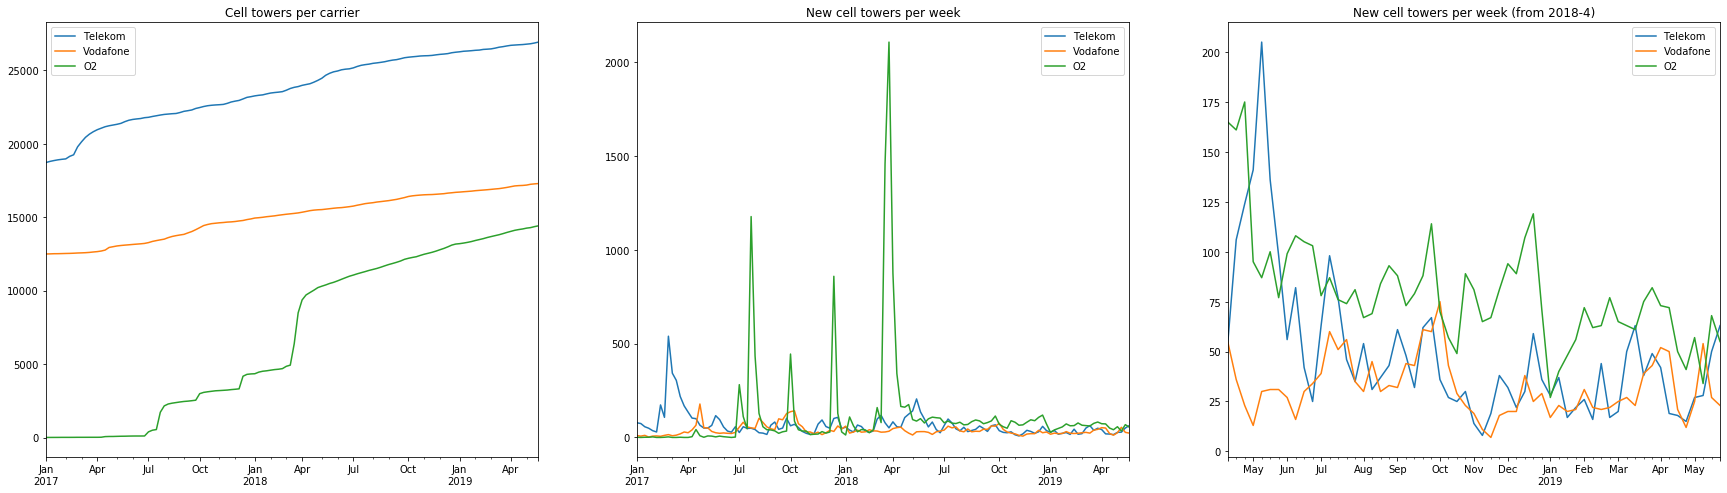

In [31]:
#towers.plot()
fig, ax = plt.subplots(ncols=3, figsize=(30,8))
towers.plot(ax=ax[0],title='Cell towers per carrier')
#plt.legend(loc='upper left')
towersNew.plot(ax=ax[1], title='New cell towers per week')
towersNewConsolidated.plot(ax=ax[2], title='New cell towers per week (from 2018-4)')

plt.show()

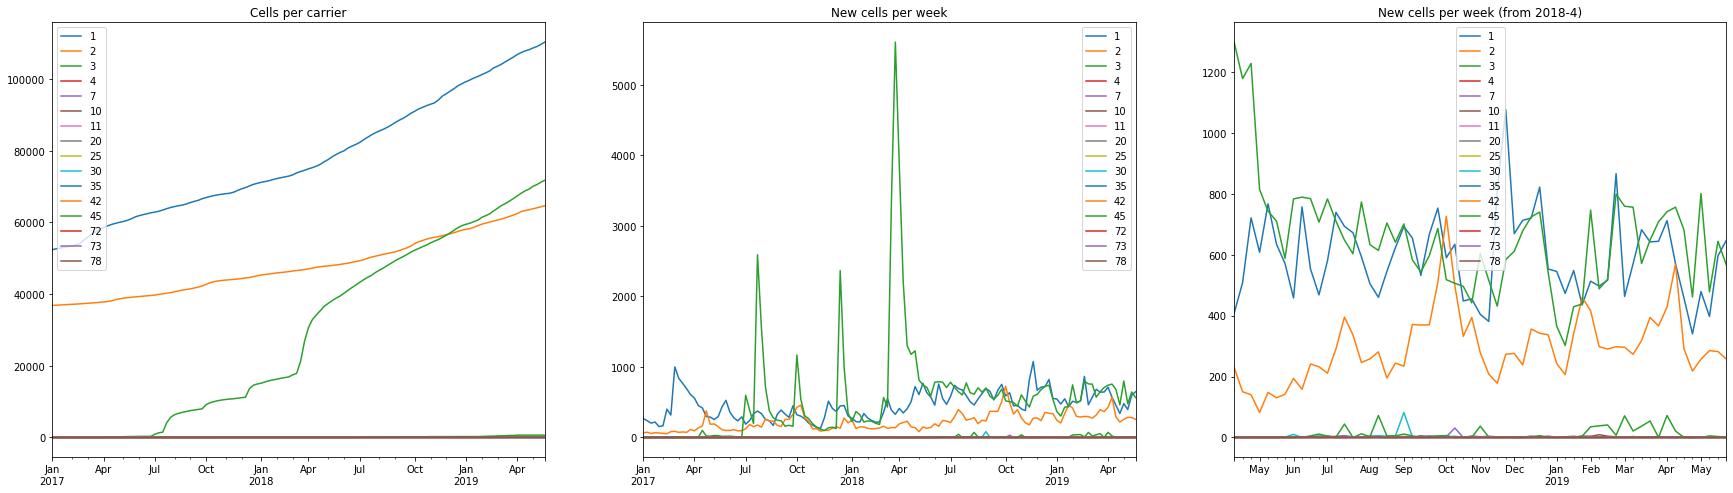

In [32]:
#towers.plot()
fig, ax = plt.subplots(ncols=3, figsize=(30,8))
n_cells.plot(ax=ax[0],title='Cells per carrier')
#plt.legend(loc='upper left')
cellsNew.plot(ax=ax[1], title='New cells per week')
cellsNewConsolidated.plot(ax=ax[2], title='New cells per week (from 2018-4)')

plt.show()

The distribution of cell towers between carriers shows as expected.

Over the last year, o2 has been closing the gap to Vodafone.

Telekom is the carrier with the most sites.

However, their conversion to single RAN is not completed yet, which means that
different frequencies broadcasted from the same tower might have different eNB ids.

Over the last year, O2 has consistently been the provider with the most newest sites per week,
ranging from around 50 to 100 sites.
Due to the O2 E-Plus merger, o2 changed its network id to 262-3 which lead to the sudden
increase of O2 sites between July 2017 and April 2018

When not looking at the towers but at the cells, O2 actually surpassed Vodafone in late 2018.
Here, the numbers of all three providers are comparable, as one single cell is always counted as one.

In [33]:
o2B1 = cellsDeLte.query('net==3 and samples>3 and sector>30 and sector<40 and cell>100000').groupby('eNB').median()
#o2B1.loc[:,'updatedP'] = pd.to_datetime(o2B1['updated'], unit="s")

o2B1['id'] = o2B1.index.values

#o2B1['createdR'] = pd.to_datetime(o2B1.created, unit="s")

### Plotting
Now, lets plot a map for each carrier. O2 is blue, Vodafone red and Telekom magenta. The maps are interactive and can be zoomed and moved.

In [78]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, GMapOptions, HoverTool, ColorBar
from bokeh.plotting import gmap, figure
from bokeh.tile_providers import STAMEN_TONER
from bokeh.layouts import row
from bokeh.transform import linear_cmap
from bokeh.palettes import Inferno

#output_file("all.html")
output_notebook()

#map_options = GMapOptions(lat=51.3, lng=10.5, map_type="roadmap", zoom=7)

# For GMaps to function, Google requires you obtain and enable an API key:
#
#     https://developers.google.com/maps/documentation/javascript/get-api-key
#
# Replace the value below with your personal API key:

def createMap(dataSource, colour, hexbin=True, size=3, mapCreate=False):


    mapTemp = figure(x_range=(700000, 1600000), y_range=(6000000, 7300000),
               x_axis_type="mercator", y_axis_type="mercator", plot_height=800, plot_width = 700)
    mapTemp.add_tile(STAMEN_TONER)
    #dataSourceConv = addWebMercartor(dataSource)
    sourceTemp = ColumnDataSource(dataSource)
    
    
        
    if hexbin:
        r, bins = mapTemp.hexbin(dataSource['lon6'].values, dataSource['lat6'].values, size=20000, hover_color="pink", hover_alpha=0.6, fill_alpha=0.1)
    #bokeh_hexbin(mapTemp, dataSourceConv['lon6'].values, dataSourceConv['lat6'].values, bins=10)
    circles = None
    if mapCreate:
        mapper = linear_cmap(field_name='created', palette=Inferno[10] ,low=min(dataSource.created) ,high=max(dataSource.created))
        circles = mapTemp.circle(x="lon6", y="lat6", size=size, fill_color=mapper, fill_alpha=0.8, source=sourceTemp, line_alpha=0, line_width=10)
        color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))

        mapTemp.add_layout(color_bar, 'right')
    else:
        circles = mapTemp.circle(x="lon6", y="lat6", size=size, fill_color=colour, fill_alpha=0.8, source=sourceTemp, line_alpha=0, line_width=10)
    hover = HoverTool()
    hover.tooltips=[('CellID', '@id'),('Samples', '@samples'), ('Created', '@createdR{%F}'),('Changed','@updated{%F}')]
    hover.formatters={'updated': 'datetime', 'createdR': 'datetime'}
    hover.renderers=[circles]
    if hexbin:
        hover2 = HoverTool(
                    tooltips=[("count", "@c"), ("(q,r)", "(@q, @r)")],
                    mode="mouse", point_policy="follow_mouse", renderers=[r])
        mapTemp.add_tools(hover2, hover)
        return mapTemp, bins
    else:
        mapTemp.add_tools(hover)
        return mapTemp, None

o2map, o2hex = createMap(o2, "blue",True)
dtmap, dthex = createMap(dt, "magenta",True)
vfmap, vfhex = createMap(vf, "red",True)
show(row(o2map, dtmap, vfmap))

Loading BokehJS ...

In [35]:
o2mapC, o2hexC = createMap(cellsDeLte.query('net==3'), "blue",True)
dtmapC, dthexC = createMap(cellsDeLte.query('net==1'), "magenta",True)
vfmapC, vfhexC = createMap(cellsDeLte.query('net==2'), "red",True)
#show(row(o2mapC, dtmapC, vfmapC))

In [67]:
# Plot new towers since dat
dat = datetime.datetime(2019,1,1)
newmap3, _ = createMap(o2.query('createdR>@dat'), "blue", False,5,True)
newmap1, _ = createMap(dt.query('createdR>@dat'), "blue", False,5,True)
newmap2, _ = createMap(vf.query('createdR>@dat'), "blue", False,5,True)
show(row(newmap3, newmap1, newmap2))

In the above plot, all new sites this year are plotted (O2, Telekom and Vodafone in this order). The dots are coloured by date of creation (lighter is newer). O2 seems to activate many sites in rural areas, where they are still rather weak compared to the other providers.

Recently, o2 has been rolling out LTE in band 1.
The map below shows the state of this rollout.
Cells are colored by creation date.

In [37]:
b1, _ = createMap(o2B1, "blue", False,10,mapCreate=True)
show(b1)

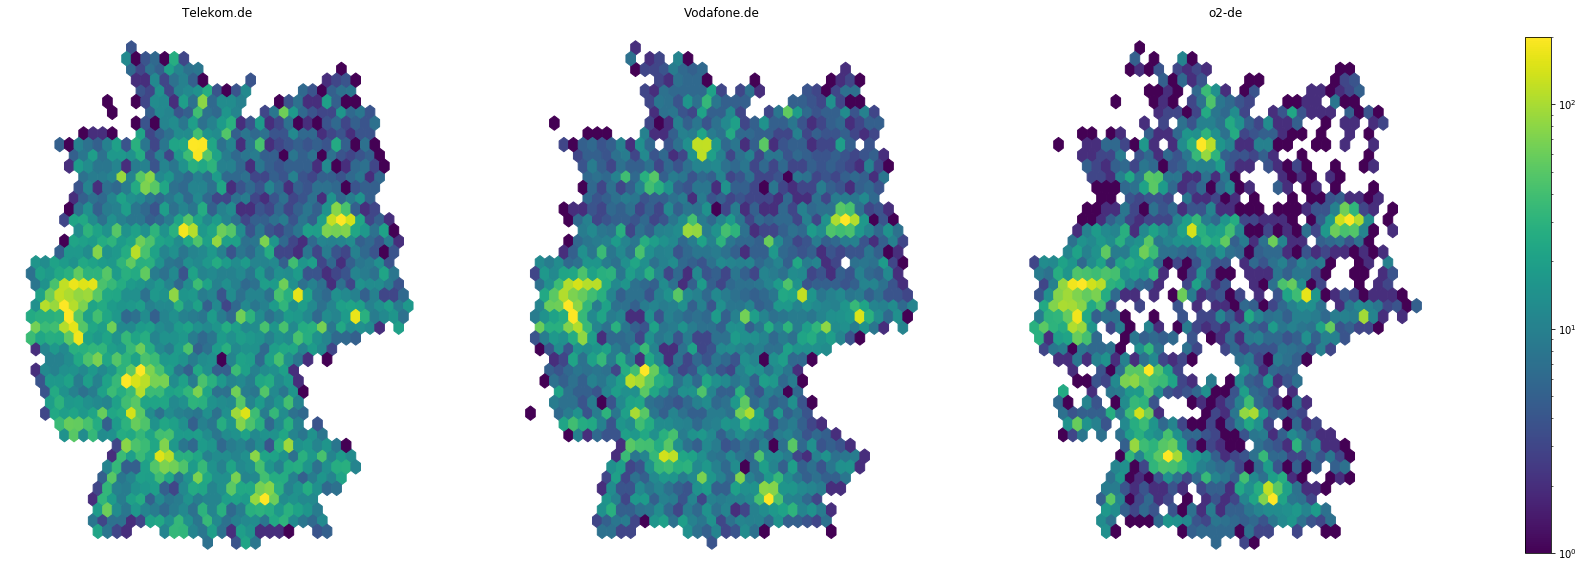

In [38]:
fig, ax = plt.subplots(ncols=3, figsize=(32,10))
#plt.figure(figsize=(12,10))
im = ax[0].hexbin(dt.lon6, dt.lat6, bins='log', gridsize=40, mincnt=1, vmax=200)
ax[0].axis('off')
ax[0].title.set_text('Telekom.de')
ax[1].hexbin(vf.lon6, vf.lat6, bins='log', gridsize=40, mincnt=1, vmax=200)
ax[1].axis('off')
ax[1].title.set_text('Vodafone.de')
ax[2].hexbin(o2.lon6, o2.lat6, bins='log', gridsize=40, mincnt=1, vmax=200)
ax[2].axis('off')
ax[2].title.set_text('o2-de')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
#ax[1].colorbar()
plt.show()

In the above plot, the density of the networks is analysed. While the density of Telekom and Vodafone seem to look similar, O2 has large, completely unserved areas (white), while the big cities seem to look similar compared to the other providers.

## Network density analysis
As seen in the previous plot, there seem to be large differences between the providers. To analyse where these differences come from, we take a closer look at the data, comparing the cell tower distribution over hexagonal bins of a size of roughly 375 km2.

In [79]:
o2hex = pd.DataFrame(o2hex)
vfhex = pd.DataFrame(vfhex)
dthex = pd.DataFrame(dthex)

In [80]:
merge1 = pd.merge(dthex, o2hex, left_on=['q','r'], right_on=['q','r'], how='outer', suffixes=('_dt','_o2'))
merged = pd.merge(merge1, vfhex, left_on=['q','r'], right_on=['q','r'], how='outer', suffixes=('','_vf'))

merged = merged.rename(columns={"counts":"counts_vf"})

merged = merged.query('r<-199').fillna(0)

In [81]:
merged = merged.query('counts_dt+counts_o2+counts_vf>2')

In [82]:
merged['summe'] = merged.counts_dt+merged.counts_vf+merged.counts_o2

In [83]:
merged['perc_dt']= merged.counts_dt/merged.summe
merged['perc_vf']= merged.counts_vf/merged.summe
merged['perc_o2']= merged.counts_o2/merged.summe

In [73]:
# for towers:140

We separate the bins into high density and the rest. The high density class contains bins that are located in the cities.
These have a much higher count of sites per bin. Around 10% of the bins are in the cities class.

In [90]:
cities = merged.query('counts_dt+counts_o2+counts_vf>=140')
rest = merged.query('counts_dt+counts_o2+counts_vf<140')

In [87]:
print(len(merged))
print(len(cities))
print(len(rest))

945
92
853


In [88]:
print(rest.sum())
print(cities.sum())

q            123725.000000
r           -189959.000000
counts_dt     15610.000000
counts_o2      6006.000000
counts_vf      9549.000000
summe         31165.000000
perc_dt         436.241232
perc_vf         276.781246
perc_o2         139.977521
dtype: float64
q            12882.000000
r           -20190.000000
counts_dt    11309.000000
counts_o2     8419.000000
counts_vf     7734.000000
summe        27462.000000
perc_dt         39.351047
perc_vf         25.465614
perc_o2         27.183339
dtype: float64


In [91]:
rest.median()

q            145.000000
r           -223.000000
counts_dt     16.000000
counts_o2      5.000000
counts_vf     10.000000
summe         30.000000
perc_dt        0.500000
perc_vf        0.313579
perc_o2        0.161726
dtype: float64

In these non-city cells, the density of towers differs greatly between providers. While O2 has a median of only 5 towers per bin, Vodafone has twice as many towers on median.
If we assume a coverage radius of 4 km for every tower and a bin size of 375 km2, we would need around 7-8 towers per hexagon to get close to full coverage. This means that O2 is massively lacking behind the two other providers for rural coverage, where area coverage is important.

If we now look at the number of bins with less than 8 towers for every provider, we can calculate how many new towers every provider needs to reach full coverage. This is probably not completely accurate due to terrain and bins that are only partially covering the coverage area of the german providers.

In [92]:
rural = merged.query('counts_o2<8')

In [93]:
counts = rural.counts_o2.sum()
nhex = len(rural)
print('Missing towers: '+str(nhex*7-counts))

Missing towers: 2454.0


In [94]:
rural = merged.query('counts_vf<8')
counts = rural.counts_o2.sum()
nhex = len(rural)
print('Missing towers: '+str(nhex*7-counts))

Missing towers: 1232.0


In [96]:
rural = merged.query('counts_dt<8')
counts = rural.counts_o2.sum()
nhex = len(rural)
print('Missing towers: '+str(nhex*7-counts))

Missing towers: 957.0


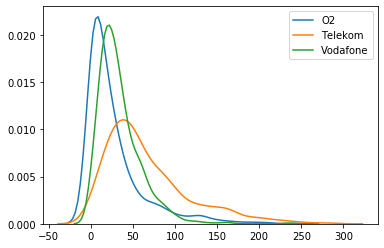

In [57]:
sns.kdeplot(rest.counts_o2, label='O2')
sns.kdeplot(rest.counts_dt, label='Telekom')
sns.kdeplot(rest.counts_vf, label='Vodafone')

Distribution plot of towers per hexagon for every provider in the non-city areas.

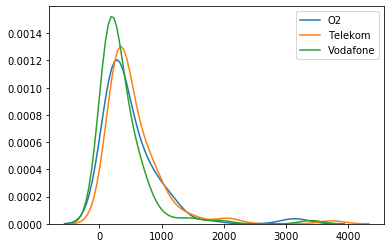

In [58]:
sns.kdeplot(cities.counts_o2, label='O2')
sns.kdeplot(cities.counts_dt, label='Telekom')
sns.kdeplot(cities.counts_vf, label='Vodafone')

Distrubution plot of towers per hexagon in the city areas. In these areas, O2 actually already surpasses Vodafone.

In [59]:
cities.median()

q            138.000000
r           -221.000000
counts_dt    368.500000
counts_o2    328.000000
counts_vf    209.000000
summe        935.500000
perc_dt        0.407742
perc_vf        0.236823
perc_o2        0.349833
dtype: float64

Following the analysis of the rural areas, we now focus on the urban areas.
Here, we can individually compare the number of sites for every provider on a bin level.

In [98]:
cities.sort_values(by='perc_dt').head(10)

q    r  counts_dt  counts_o2  counts_vf   summe   perc_dt   perc_vf  \
158  134 -208      166.0      193.0      152.0   511.0  0.324853  0.297456   
142  134 -224      140.0      165.0      103.0   408.0  0.343137  0.252451   
845  157 -229      124.0      128.0      107.0   359.0  0.345404  0.298050   
703  151 -223      152.0      165.0      118.0   435.0  0.349425  0.271264   
706  151 -220       50.0       40.0       53.0   143.0  0.349650  0.370629   
131  133 -208      155.0      157.0      131.0   443.0  0.349887  0.295711   
104  132 -209       71.0       75.0       55.0   201.0  0.353234  0.273632   
844  157 -230       65.0       66.0       53.0   184.0  0.353261  0.288043   
157  134 -209       88.0       93.0       67.0   248.0  0.354839  0.270161   
865  158 -230      581.0      570.0      486.0  1637.0  0.354918  0.296885   

      perc_o2  
158  0.377691  
142  0.404412  
845  0.356546  
703  0.379310  
706  0.279720  
131  0.354402  
104  0.373134  
844  0.358696  
157  0.375000  
865  0.348198

In [99]:
cities.sort_values(by='perc_vf').head(10)

q    r  counts_dt  counts_o2  counts_vf  summe   perc_dt   perc_vf  \
397  142 -228       74.0       47.0       27.0  148.0  0.500000  0.182432   
238  137 -215       91.0       43.0       30.0  164.0  0.554878  0.182927   
362  141 -227      147.0       71.0       51.0  269.0  0.546468  0.189591   
327  140 -226       74.0       44.0       28.0  146.0  0.506849  0.191781   
606  148 -228      128.0       82.0       56.0  266.0  0.481203  0.210526   
170  135 -223      128.0      119.0       68.0  315.0  0.406349  0.215873   
257  138 -227       69.0       47.0       32.0  148.0  0.466216  0.216216   
12   127 -204       83.0       54.0       38.0  175.0  0.474286  0.217143   
237  137 -216       86.0       42.0       36.0  164.0  0.524390  0.219512   
740  153 -241      102.0       82.0       52.0  236.0  0.432203  0.220339   

      perc_o2  
397  0.317568  
238  0.262195  
362  0.263941  
327  0.301370  
606  0.308271  
170  0.377778  
257  0.317568  
12   0.308571  
237  0.256098  
740  0.347458

In [100]:
cities.sort_values(by='perc_o2').head(10)

q    r  counts_dt  counts_o2  counts_vf  summe   perc_dt   perc_vf  \
303  139 -214       95.0       18.0       51.0  164.0  0.579268  0.310976   
876  159 -240       69.0       22.0       63.0  154.0  0.448052  0.409091   
544  146 -221       68.0       25.0       68.0  161.0  0.422360  0.422360   
453  143 -209       85.0       23.0       40.0  148.0  0.574324  0.270270   
122  133 -217       82.0       25.0       44.0  151.0  0.543046  0.291391   
381  141 -208      108.0       34.0       56.0  198.0  0.545455  0.282828   
187  135 -206       87.0       38.0       73.0  198.0  0.439394  0.368687   
177  135 -216       76.0       32.0       49.0  157.0  0.484076  0.312102   
786  154 -221       61.0       33.0       64.0  158.0  0.386076  0.405063   
278  138 -206       95.0       48.0       76.0  219.0  0.433790  0.347032   

      perc_o2  
303  0.109756  
876  0.142857  
544  0.155280  
453  0.155405  
122  0.165563  
381  0.171717  
187  0.191919  
177  0.203822  
786  0.208861  
278  0.219178

Cities where O2 performs badly in this metric are in the order of the table Würzburg, Rosdock, Erfurt Regensburg, Koblenz, Ingolstadt, Ulm, Dresden and Augsburg.